# Wave Function examples

In [2]:
import math
import cmath

from crsq.slater import ARegister, ARegisterFrame
from crsq.slater import BRegister, BRegisterFrame
import crsq.amplitudes as amplitudes

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram

## Slater determinant preparation
### Creation of sums

The following state is prepared:

```{math}
\ket{B}=\frac{1}{4!}(\ket{3}+\ket{2}+\ket{1}+\ket{0})\otimes(\ket{2}+\ket{1}+\ket{0})\otimes(\ket{1}+\ket{0})\otimes(\ket{0})
```

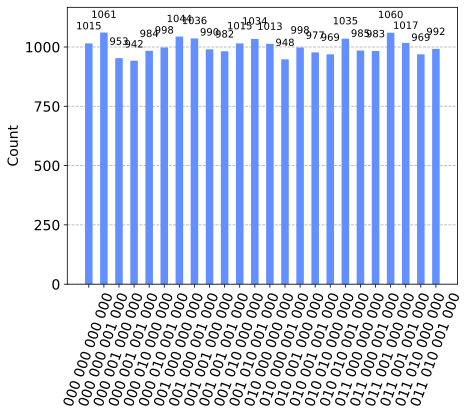

In [4]:
n=3
N=4
d=1
NN = math.factorial(N)
M=1000

breg = BRegister(n, N, 1)
breg.set_use_custom_gates(True)
breg.set_should_swap_aregs(False)
breg.allocate_registers()

frame = breg.frame
base = frame.base
qc = base.circuit
bregs = frame.bregs

cregs = [ClassicalRegister(n) for _ in range(N)]
qc.add_register(*cregs)

breg.build_sums(frame)

for i in range(N):
    qc.measure(bregs[i], cregs[i])

backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend), shots=M*NN).result()
counts = result.get_counts(qc)

plot_histogram(counts)

### Creation of permutations

The following state is prepared:

```{math}
\ket{B}=\sum_{\sigma \in S_4}\rm{sgn}(\sigma)\ket{\sigma}
```

However, through the histogram, the sign cannot be confirmed.

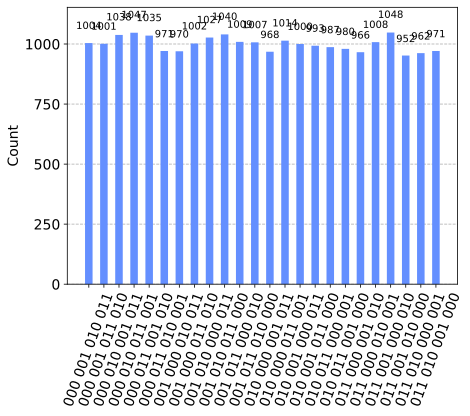

In [5]:
n=3
N=4
d=1
NN = math.factorial(N)
M=1000

breg = BRegister(n, N, 1)
breg.set_use_custom_gates(True)
breg.set_should_swap_aregs(False)
breg.allocate_registers()
frame = breg.frame
base = frame.base
qc = base.circuit
bregs = frame.bregs

cregs = [ClassicalRegister(n) for _ in range(N)]
qc.add_register(*cregs)

breg.build_sums(frame)
qc.barrier()
breg.build_permutations(frame)

for i in range(N):
    qc.measure(bregs[i], cregs[i])

backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend), shots=M*NN).result()
counts = result.get_counts(qc)

plot_histogram(counts)

### Check permutation including the sgn(σ)

This time the state vector is inspected and the phase is confirmed.

The following state is prepared.

```{math}
\ket{B}=\sum_{\sigma \in S_4}\rm{sgn}(\sigma)\ket{\sigma}
```

In [6]:
n=2
N=4
m=2
d=1

M=1

NN = math.factorial(N)

breg = BRegister(n, N, d)
breg.set_use_custom_gates(True)
areg = ARegister(m, N, d)

breg.set_areg(areg)
breg.allocate_registers()

frame = breg.frame
base = frame.base
qc = base.circuit

cregs = [ClassicalRegister(n) for _ in range(N*2)]
qc.add_register(*cregs)

areg.set_test_values(frame.areg_frame)

breg.build_sums(frame)
breg.build_permutations(frame)
qc.save_statevector()

backend = AerSimulator()
result = backend.run(transpile(qc, backend), shots=1).result()
sv = result.get_statevector()

eps=1e-6
ieps=1e+6

for k, z in sorted(sv.to_dict().items(), reverse=True):
    r = abs(z)
    if r > eps:
        amp = amplitudes.format_in_polar(z)
        nums = []
        for j in range(N):
            i = int(k[j*2:j*2+2],base=2)
            nums.append(str(i))
        vec= "[" + ",".join(nums) + "]"
        print(f"{k} : {vec} {amp} z={z:.6f} |z|={r:.6f}")


111001000111010101000 : [3,2,1,0] 0.204124 z=0.204124-0.000000j |z|=0.204124
111000010111010000101 : [3,2,0,1] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
110110000111101010000 : [3,1,2,0] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
110100100111101000010 : [3,1,0,2] 0.204124 z=0.204124-0.000000j |z|=0.204124
110010010111000010101 : [3,0,2,1] 0.204124 z=0.204124-0.000000j |z|=0.204124
110001100111000101010 : [3,0,1,2] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
101101000010111101000 : [2,3,1,0] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
101100010010111000101 : [2,3,0,1] 0.204124 z=0.204124-0.000000j |z|=0.204124
100111000010101111000 : [2,1,3,0] 0.204124 z=0.204124-0.000000j |z|=0.204124
100100110010101000111 : [2,1,0,3] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
100011010010000111101 : [2,0,3,1] 0.204124*exp(3.141593j) z=-0.204124+0.000000j |z|=0.204124
100001110010000101111 : [2,0,1,3] 0.204124 z=0.204124-0.0

## State preparation

### initializing qubits with array data

00 : z=0.316228-0.000000j |z|=0.316228 p=0.100000
01 : z=0.000000+0.447214j |z|=0.447214 p=0.200000
10 : z=-0.547723+0.000000j |z|=0.547723 p=0.300000
11 : z=0.000000-0.632456j |z|=0.632456 p=0.400000


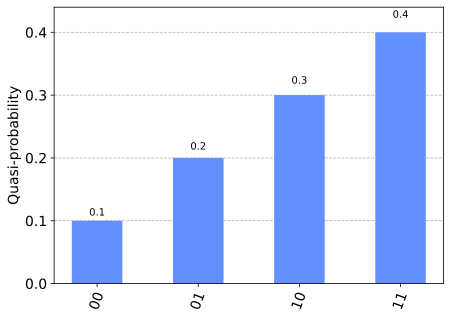

In [7]:
import numpy as np
import crsq.setdistribution as sdist

qr = QuantumRegister(2, "R")
qc = QuantumCircuit(qr)
cn = np.array([np.sqrt(1/10), np.sqrt(2/10)*1j, -np.sqrt(3/10), np.sqrt(4/10)*-1j])
sdist.setdist(qc, qr, cn)
qc.save_statevector()

backend = AerSimulator(method='automatic')
transpiled = transpile(qc, backend)
result = backend.run(transpiled, shots=100*len(cn)).result()
sv = result.get_statevector()
#sv.draw('latex')
counts = result.get_counts()

eps=1.0e-8
for k, z in sorted(sv.to_dict().items()):
    r = abs(z)
    if r > eps:
        print(f"{k} : z={z:.6f} |z|={r:.6f} p={r*r:.6f}")

plot_histogram(counts)

00000 : z=0.133850-0.000000j |z|=0.133850 p=0.017916
00001 : z=0.000000+0.151672j |z|=0.151672 p=0.023004
00010 : z=-0.171867+0.000000j |z|=0.171867 p=0.029538
00011 : z=-0.000000-0.194751j |z|=0.194751 p=0.037928
00100 : z=0.220682-0.000000j |z|=0.220682 p=0.048700
00101 : z=0.000000+0.250065j |z|=0.250065 p=0.062533
00110 : z=-0.283361+0.000000j |z|=0.283361 p=0.080293
00111 : z=-0.000000-0.321090j |z|=0.321090 p=0.103099
01000 : z=0.363843-0.000000j |z|=0.363843 p=0.132381
01001 : z=0.000000+0.321090j |z|=0.321090 p=0.103099
01010 : z=-0.283361+0.000000j |z|=0.283361 p=0.080293
01011 : z=-0.000000-0.250065j |z|=0.250065 p=0.062533
01100 : z=0.220682-0.000000j |z|=0.220682 p=0.048700
01101 : z=0.000000+0.194751j |z|=0.194751 p=0.037928
01110 : z=-0.171867+0.000000j |z|=0.171867 p=0.029538
01111 : z=-0.000000-0.151672j |z|=0.151672 p=0.023004
10000 : z=0.133850-0.000000j |z|=0.133850 p=0.017916
10001 : z=0.000000+0.118122j |z|=0.118122 p=0.013953
10010 : z=-0.104243+0.000000j |z|=0.10

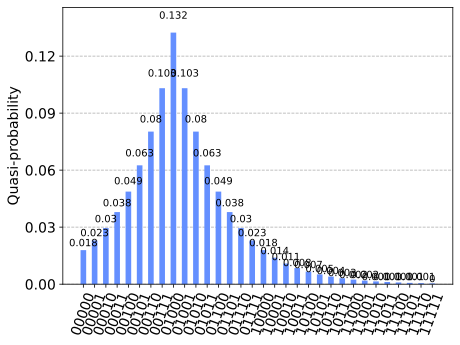

In [8]:
qr = QuantumRegister(5, "R")
qc = QuantumCircuit(qr)
cn = np.array([cmath.exp(-(np.abs(n-8)/8)+0.5j*np.pi*n) for n in range(32)])
sdist.setdist(qc, qr, cn)
qc.save_statevector()

backend = AerSimulator(method='automatic')
transpiled = transpile(qc, backend)
result = backend.run(transpiled, shots=100*len(cn)).result()
sv = result.get_statevector()
counts = result.get_counts()

eps=1.0e-8
for k, z in sorted(sv.to_dict().items()):
    r = abs(z)
    if r > eps:
        print(f"{k} : z={z:.6f} |z|={r:.6f} p={r*r:.6f}")

plot_histogram(counts)